In [ ]:
import torch
import torchvision

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import glob
import os
import zipfile
import requests
import numpy as np
import copy

from tqdm import tqdm
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
from collections import Counter
from pathlib import Path
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
!gdown --fuzzy 18Jo6WPyY-Gjaw2osYuy5bPopHhTyBQLK

Downloading...
From (original): https://drive.google.com/uc?id=18Jo6WPyY-Gjaw2osYuy5bPopHhTyBQLK
From (redirected): https://drive.google.com/uc?id=18Jo6WPyY-Gjaw2osYuy5bPopHhTyBQLK&confirm=t&uuid=982ab766-07df-4f49-a22d-3038a3f08c9b
To: /content/AnatomyRec (1).rar
100% 83.6M/83.6M [00:01<00:00, 46.5MB/s]


In [ ]:
!ls /content/dataset/AnatomyRec_FF

ls: cannot access '/content/dataset/AnatomyRec_FF': No such file or directory


In [ ]:
!mv 'AnatomyRec (1).rar' dataset.rar

In [ ]:
!apt-get install -y unrar
!unrar x dataset.rar dataset/

Streaming output truncated to the last 5000 lines.
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-89.png                    62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-8991.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-906.png                   62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9069.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9070.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9071.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9072.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9073.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9074.png                  62%  OK 
Extracting  dataset/AnatomyRec_FF/KNEE-KNEE_LAT-9075.png                  62%  OK 
Extracting  dataset/AnatomyRe

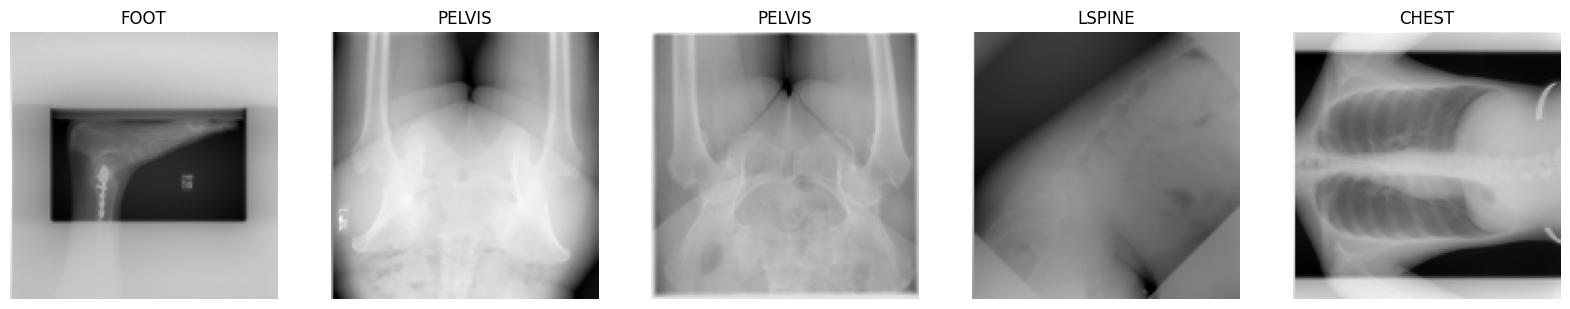

In [ ]:
def load_images_from_dir(root_dir,ext=('.png', '.jpg', '.jpeg')):
    image_paths = []
    labels = []
    for path in Path(root_dir).rglob('*'):
        if path.suffix.lower() in ext:
            filename = path.stem  # npr. 'CHEST-CHEST_PA-8424'
            label = filename.split('-')[0].upper()  # uzmi deo pre prvog '-' i pretvori u velika slova
            image_paths.append(str(path))
            labels.append(label)
    return image_paths, labels

img_paths, labels = load_images_from_dir('/content/dataset/AnatomyRec_FF')
#print(list(zip(img_paths[:5], labels[:5])))

sample_indices = random.sample(range(len(img_paths)), 5)

plt.figure(figsize=(20, 5))

for i, idx in enumerate(sample_indices):
    img = Image.open(img_paths[idx])
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(labels[idx])
    plt.axis('off')
plt.show()



In [ ]:
num_classes = len(set(labels))
unique_labels = sorted(set(labels))
print("Broj različitih labela:", num_classes)
print("Sve različite labele:", unique_labels)

label_counts = Counter(labels)
print("Broj slika po labeli:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Broj različitih labela: 19
Sve različite labele: ['ABDOMEN', 'ANKLE', 'ARM', 'CHEST', 'CSPINE', 'ELBOW', 'FOOT', 'HAND', 'HIP', 'KNEE', 'LEG', 'LOWERARM', 'LSPINE', 'PATELLA', 'PELVIS', 'SHOULDER', 'SKULL', 'TSPINE', 'WRIST']
Broj slika po labeli:
CHEST: 2202
KNEE: 1251
WRIST: 389
LSPINE: 2068
SKULL: 408
CSPINE: 1247
ANKLE: 587
PELVIS: 660
HAND: 1023
SHOULDER: 599
TSPINE: 337
ABDOMEN: 327
HIP: 227
FOOT: 1077
ELBOW: 219
ARM: 161
LEG: 275
PATELLA: 143
LOWERARM: 87


In [ ]:
class XrayDataset(Dataset):
    def __init__(self, image_paths, labels, label2idx=None, transform=None):
        """
        Args:
            image_paths (list): Lista putanja do slika
            labels (list): Lista labela (string)
            label2idx (dict): Mapiranje string labela na indeks (npr. {'CHEST':0, 'KNEE':1, ...})
            transform: torchvision.transforms za obradu slike
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        # Ako nije prosleđen label2idx, napravi ga automatski
        if label2idx is None:
            unique_labels = sorted(set(labels))
            self.label2idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        else:
            self.label2idx = label2idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_str = self.labels[idx]
        label = self.label2idx[label_str]  # labelu u indeks

        # otvori sliku
        img = Image.open(img_path).convert('L')

        # ako postoji transformacija (resize, normalize, augmentacije...)
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        return img, label

In [ ]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    img_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")

# Transformacije
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomAffine(
        degrees=15,              # rotacija ±15°
        translate=(0.05, 0.05),  # translacija do 5% širine/visine
        scale=(0.9, 1.1)         # skaliranje od 90% do 110%
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset-i
train_dataset = XrayDataset(train_paths, train_labels, transform=train_transform)
val_dataset = XrayDataset(val_paths, val_labels, label2idx=train_dataset.label2idx, transform=val_test_transform)
test_dataset = XrayDataset(test_paths, test_labels, label2idx=train_dataset.label2idx, transform=val_test_transform)

# DataLoader-i
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Train: 10629, Validation: 1329, Test: 1329


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Proba: da vidimo batch
images, labels_ = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labeli:", labels_[:10])

Batch shape: torch.Size([32, 1, 256, 256])
Labeli: tensor([12,  1,  3, 12,  4,  9, 15,  3,  1,  9])


In [ ]:
print("Mapiranje labela:", train_dataset.label2idx)

Mapiranje labela: {'ABDOMEN': 0, 'ANKLE': 1, 'ARM': 2, 'CHEST': 3, 'CSPINE': 4, 'ELBOW': 5, 'FOOT': 6, 'HAND': 7, 'HIP': 8, 'KNEE': 9, 'LEG': 10, 'LOWERARM': 11, 'LSPINE': 12, 'PATELLA': 13, 'PELVIS': 14, 'SHOULDER': 15, 'SKULL': 16, 'TSPINE': 17, 'WRIST': 18}


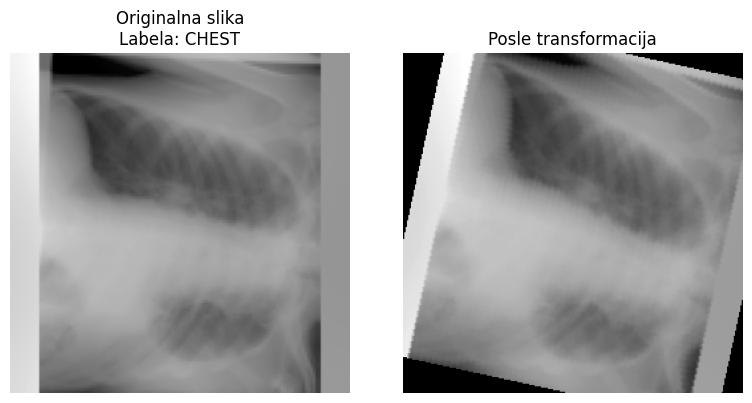

In [ ]:
idx = random.randint(0, len(train_dataset) - 1)
img_path = img_paths[idx]
label = labels[idx]

# Učitaj originalnu (neobrađenu) sliku
original_img = Image.open(img_path).convert('L')

# Primeni iste transformacije kao u datasetu
transformed_img = train_transform(original_img)

# Pretvori tensor nazad u sliku za prikaz
transformed_img_display = transformed_img.clone()
if transformed_img_display.requires_grad:
    transformed_img_display = transformed_img_display.detach()

# Denormalizacija (jer Normalize menja kontrast)
transformed_img_display = transformed_img_display * 0.5 + 0.5  # obrnuto od mean/std = 0.5

# Pretvori iz (1, H, W) u (H, W) da bi plt.imshow mogao da prikaže grayscale
transformed_img_display = transformed_img_display.squeeze().numpy()

# Prikaz
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title(f"Originalna slika\nLabela: {label}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_img_display, cmap='gray')
plt.title("Posle transformacija")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model.features.conv0 = nn.Conv2d(
    in_channels=1,   # 1 kanal umesto 3
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

# Prilagodi poslednji sloj da ima onoliko klasa koliko tvoj dataset ima
num_classes = len(train_dataset.label2idx)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Proba sa dummy batchom (npr. [32,1,224,224])
x = torch.randn(32, 1, 224, 224)
out = model(x)
print(out.shape)

torch.Size([32, 19])


In [ ]:
summary(model=model,
        input_size=(32, 1, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 1, 224, 224]    [32, 19]             --                   True
├─Sequential (features)                       [32, 1, 224, 224]    [32, 1024, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 1, 224, 224]    [32, 64, 112, 112]   3,136                True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Korišćen uređaj:", device)

model = model.to(device)

Korišćen uređaj: cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,        # broj epoha do prvog restarta
    T_mult=2,     # svaki sledeći restart traje duže
    eta_min=1e-6  # minimalni LR
)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
   # optimizer,
    #mode='min',      # gledamo da validacioni loss bude što manji
    #factor=0.5,      # smanji LR na polovinu kada nema poboljšanja
   # patience=5,      # čekaj 3 epohe bez poboljšanja pre smanjenja
#)

In [ ]:
num_epochs = 30
patience = 7  # broj epoha bez poboljšanja posle kojeg se prekida trening
best_val_loss = np.inf
early_stop_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = correct_train / total_train

    # VALIDACIJA
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = correct_val / total_val

    scheduler.step(epoch_val_loss)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}%")
    print(f"Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc*100:.2f}%")

    # EARLY STOPPING
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}")
            break

# učitaj najbolje težine
model.load_state_dict(best_model_wts)
print("\n Najbolji model učitan sa minimalnim validation loss-om!")


 Epoch 1/30
Train Loss: 1.1376 | Train Acc: 68.14%
Val Loss:   0.5838 | Val Acc:   82.62%

 Epoch 2/30
Train Loss: 0.5179 | Train Acc: 84.54%
Val Loss:   0.4490 | Val Acc:   87.28%

 Epoch 3/30
Train Loss: 0.3931 | Train Acc: 87.82%
Val Loss:   0.3737 | Val Acc:   88.64%

 Epoch 4/30
Train Loss: 0.3421 | Train Acc: 89.42%
Val Loss:   0.3461 | Val Acc:   89.77%

 Epoch 5/30
Train Loss: 0.2887 | Train Acc: 91.02%
Val Loss:   0.3527 | Val Acc:   89.01%

 Epoch 6/30
Train Loss: 0.2666 | Train Acc: 91.56%
Val Loss:   0.3110 | Val Acc:   91.12%

 Epoch 7/30
Train Loss: 0.2273 | Train Acc: 92.81%
Val Loss:   0.3320 | Val Acc:   90.37%

 Epoch 8/30
Train Loss: 0.2213 | Train Acc: 92.88%
Val Loss:   0.2897 | Val Acc:   91.80%

 Epoch 9/30
Train Loss: 0.1904 | Train Acc: 93.78%
Val Loss:   0.3127 | Val Acc:   91.65%

 Epoch 10/30
Train Loss: 0.1863 | Train Acc: 94.06%
Val Loss:   0.2880 | Val Acc:   91.42%

 Epoch 11/30
Train Loss: 0.1633 | Train Acc: 94.71%
Val Loss:   0.3278 | Val Acc:   90.9

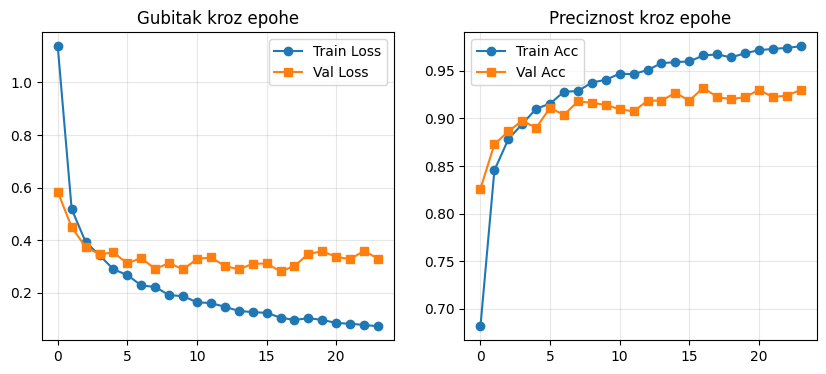

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.title('Gubitak kroz epohe')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs, label='Val Acc', marker='s')
plt.title('Preciznost kroz epohe')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
precision = precision_score(all_labels, all_preds, average='macro')  # or 'micro', 'weighted'
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.9413, Precision: 0.8964, Recall: 0.8901, F1: 0.8906


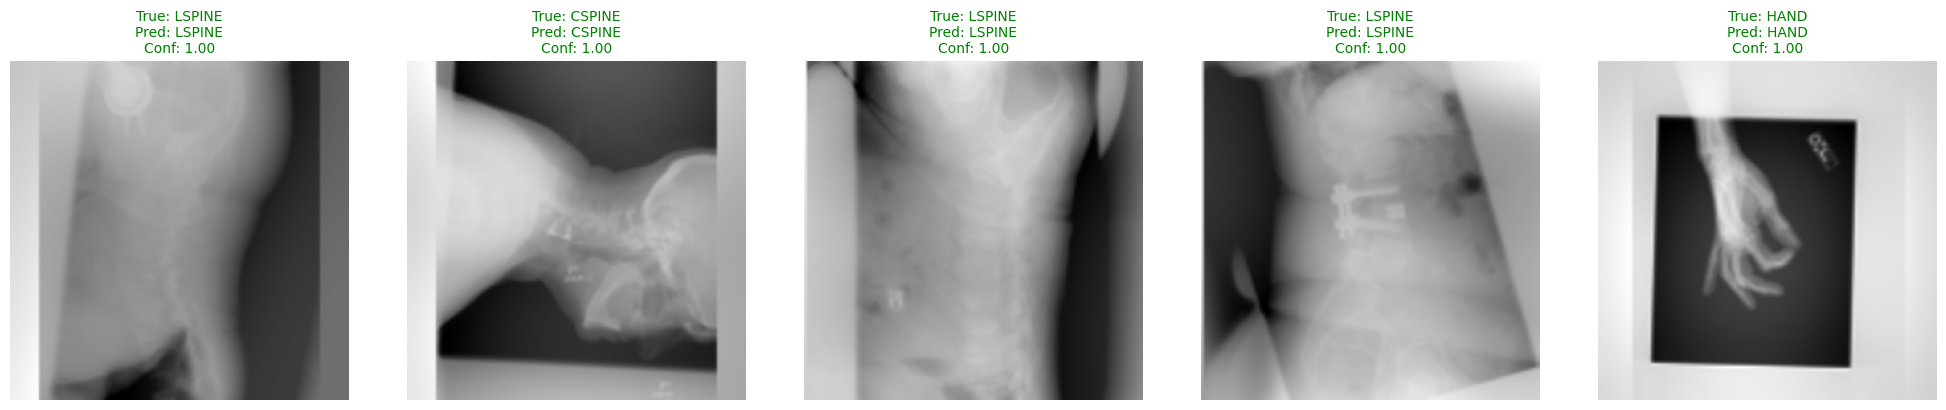

In [ ]:
def visualize_predictions(model, test_dataset, num_images=5):
    """
    Prikazuje slike iz test seta sa modelovim predikcijama
    """
    model.eval()

    # Uzmi nasumične indekse iz test seta
    indices = np.random.choice(len(test_dataset), num_images, replace=False)

    # Kreiraj figure
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    if num_images == 1:
        axes = [axes]

    # Reverse mapping za labele
    idx2label = {v: k for k, v in test_dataset.label2idx.items()}

    with torch.no_grad():
      device = next(model.parameters()).device  # Uređaj modela

    for i, idx in enumerate(indices):
        image, true_label_idx = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)  # prebaci sliku na isti uređaj

        outputs = model(image_batch)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)

        image_np = image.numpy().transpose(1, 2, 0)
        image_np = image_np * 0.5 + 0.5
        axes[i].imshow(image_np.squeeze(), cmap='gray')

        true_label = idx2label[int(true_label_idx)]
        predicted_label = idx2label[predicted_idx.item()]
        confidence = predicted_prob.item()

        color = 'green' if true_label == predicted_label else 'red'
        title = f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"
        axes[i].set_title(title, color=color, fontsize=10)
        axes[i].axis('off')

        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

# Pozovite funkciju
visualize_predictions(model, test_dataset, num_images=5)

In [ ]:
def quick_accuracy_check(model, dataloader, device, num_batches=5):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = correct / total if total > 0 else 0
    print(f"\nQuick accuracy check ({num_batches} batch-eva):")
    print(f"   Tačno: {correct}/{total}")
    print(f"   Tačnost: {acc*100:.2f}%")

    model.train()
    return acc

print(" Running quick check on validation set...")
val_accuracy = quick_accuracy_check(model, val_loader, device , num_batches=5)

print("\n Running quick check on test set...")
test_accuracy = quick_accuracy_check(model, test_loader, device , num_batches=5)

 Running quick check on validation set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Quick accuracy check (5 batch-eva):
   Tačno: 150/160
   Tačnost: 93.75%

 Running quick check on test set...

Quick accuracy check (5 batch-eva):
   Tačno: 153/160
   Tačnost: 95.62%


ANALIZA ANATOMSKOG DATASET-A

 VALIDATION SET ANALIZA
Računanje predikcija za matricu konfuzije...


Processing: 100%|██████████| 42/42 [00:05<00:00,  7.29it/s]


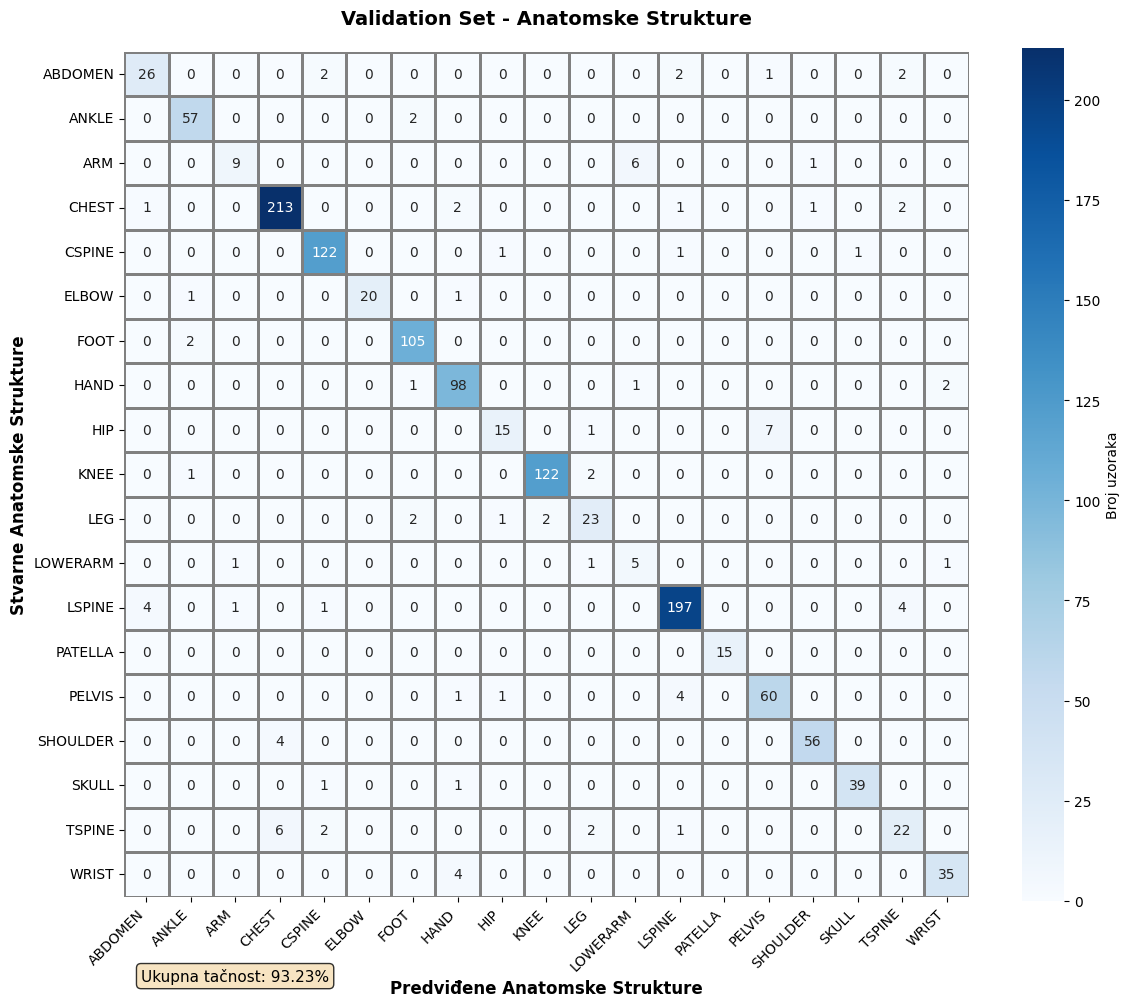

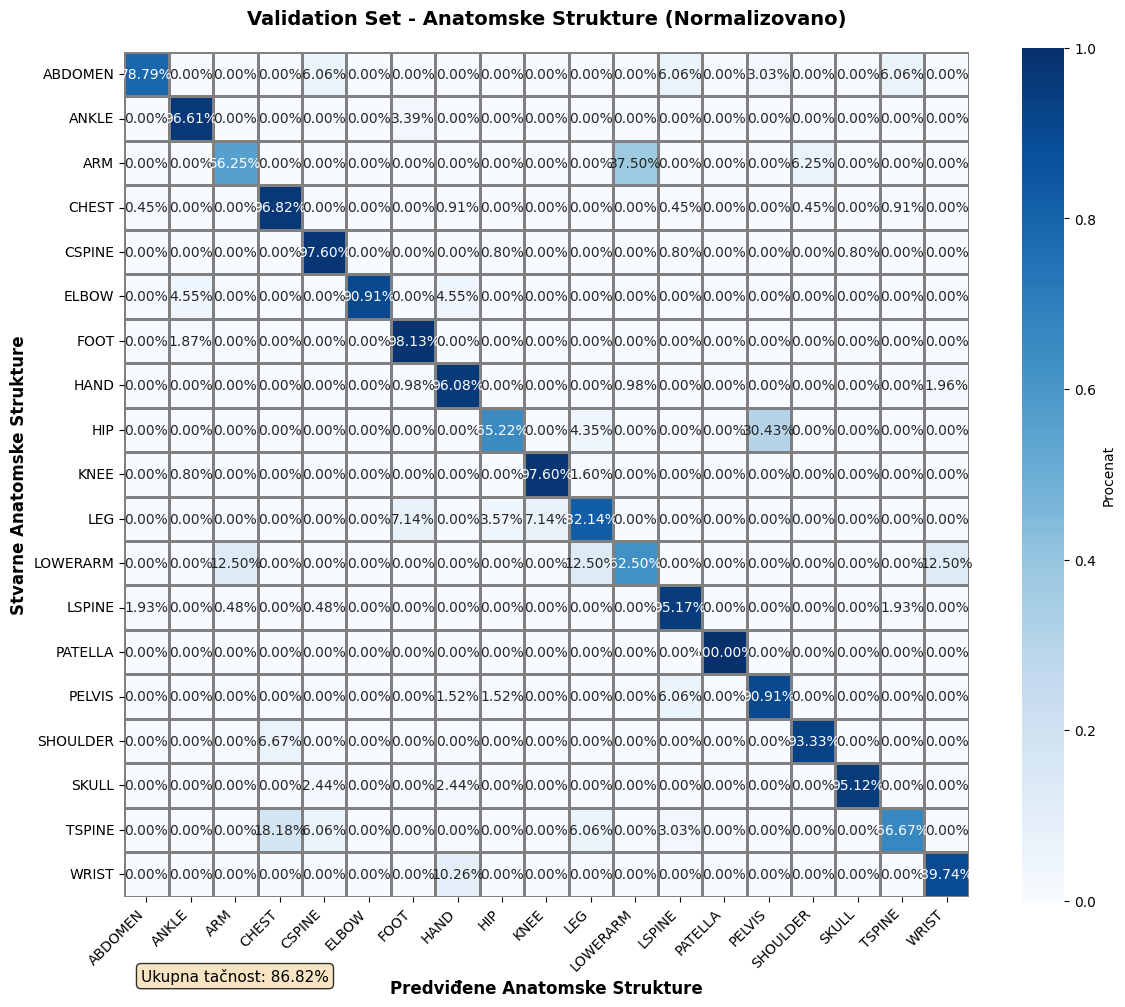

IZVEŠTAJ O KLASIFIKACIJI - ANATOMIJA
              precision    recall  f1-score   support

     ABDOMEN       0.84      0.79      0.81        33
       ANKLE       0.93      0.97      0.95        59
         ARM       0.82      0.56      0.67        16
       CHEST       0.96      0.97      0.96       220
      CSPINE       0.95      0.98      0.96       125
       ELBOW       1.00      0.91      0.95        22
        FOOT       0.95      0.98      0.97       107
        HAND       0.92      0.96      0.94       102
         HIP       0.83      0.65      0.73        23
        KNEE       0.98      0.98      0.98       125
         LEG       0.79      0.82      0.81        28
    LOWERARM       0.42      0.62      0.50         8
      LSPINE       0.96      0.95      0.95       207
     PATELLA       1.00      1.00      1.00        15
      PELVIS       0.88      0.91      0.90        66
    SHOULDER       0.97      0.93      0.95        60
       SKULL       0.97      0.95      0.96 

Processing:   0%|          | 0/42 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Processing: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


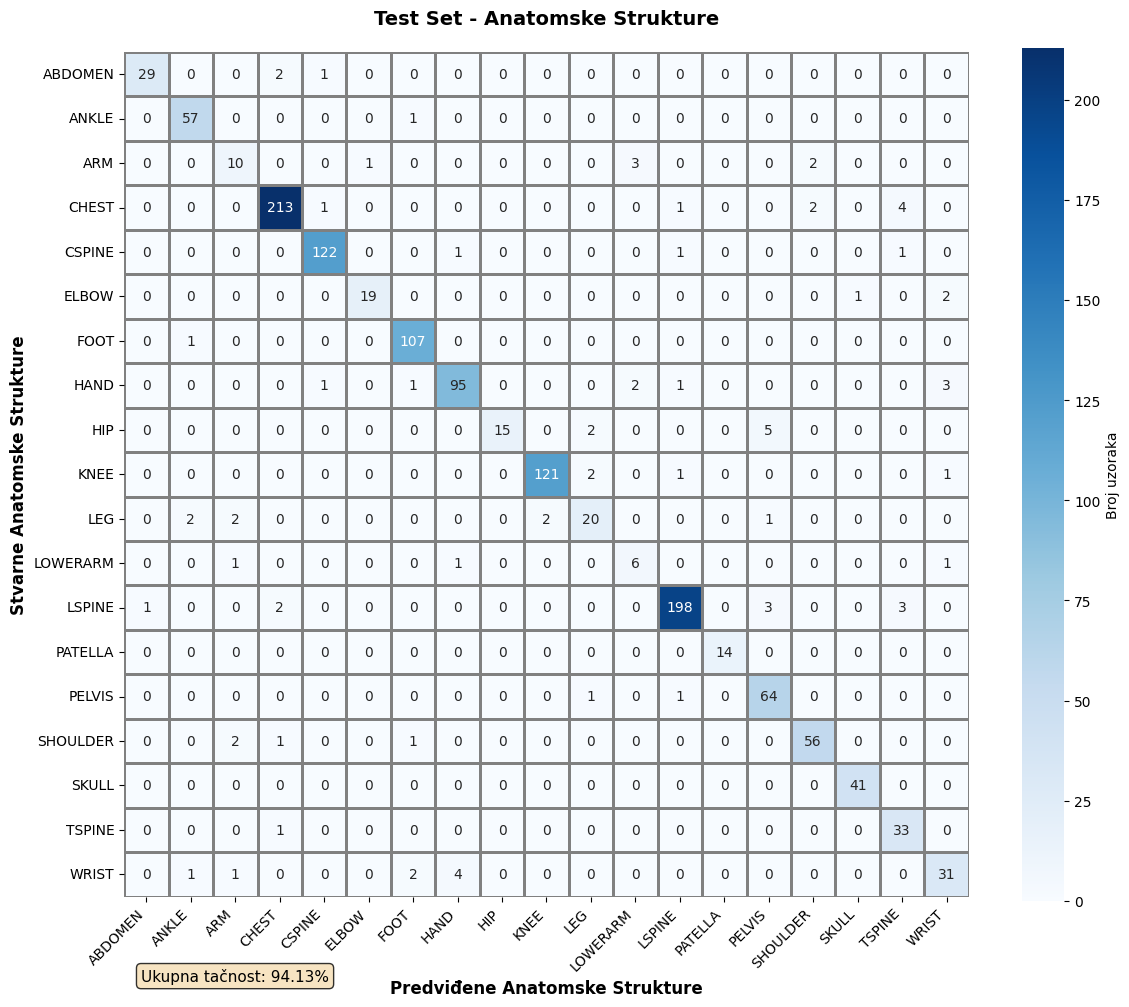

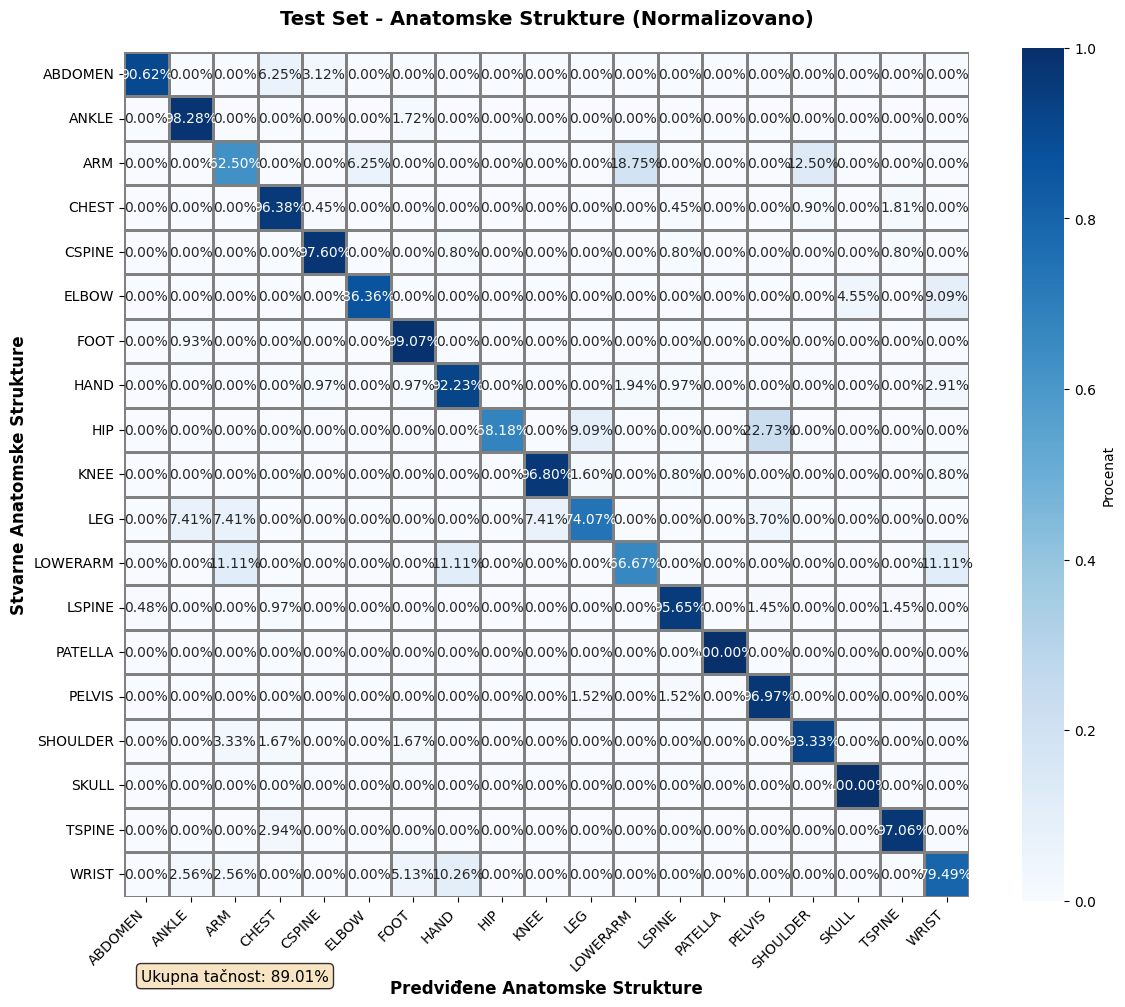

IZVEŠTAJ O KLASIFIKACIJI - ANATOMIJA
              precision    recall  f1-score   support

     ABDOMEN       0.97      0.91      0.94        32
       ANKLE       0.93      0.98      0.96        58
         ARM       0.62      0.62      0.62        16
       CHEST       0.97      0.96      0.97       221
      CSPINE       0.98      0.98      0.98       125
       ELBOW       0.95      0.86      0.90        22
        FOOT       0.96      0.99      0.97       108
        HAND       0.94      0.92      0.93       103
         HIP       1.00      0.68      0.81        22
        KNEE       0.98      0.97      0.98       125
         LEG       0.80      0.74      0.77        27
    LOWERARM       0.55      0.67      0.60         9
      LSPINE       0.98      0.96      0.97       207
     PATELLA       1.00      1.00      1.00        14
      PELVIS       0.88      0.97      0.92        66
    SHOULDER       0.93      0.93      0.93        60
       SKULL       0.98      1.00      0.99 

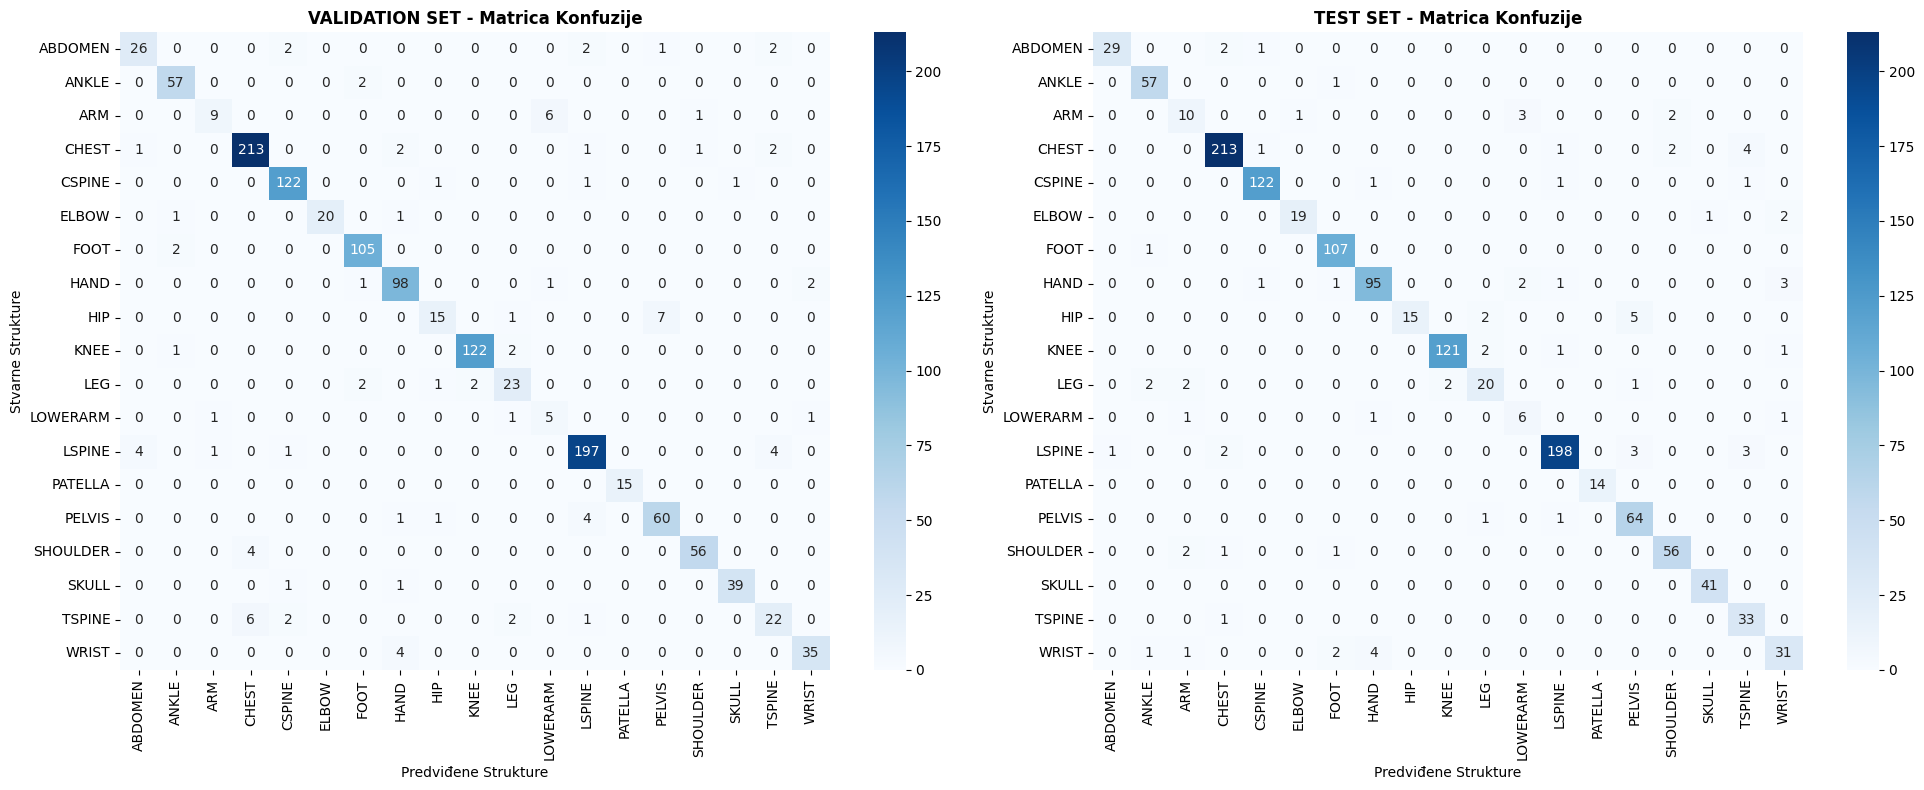


 UPOREDNA TAČNOST:
   Validation set: 93.23%
   Test set: 94.13%
   Razlika: 0.90%


In [ ]:
def compute_confusion_matrix_anatomy(model, dataloader, device, class_names, detection_threshold=0.5):
    """
    Prilagođeno za AnatomyRec_FF dataset - KLASIFIKACIJA, ne detekcija!
    """
    model.eval()
    y_true = []
    y_pred = []

    print("Računanje predikcija za matricu konfuzije...")

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Processing"):
            images = images.to(device)
            labels = labels.to(device)

            # Za KLASIFIKACIONE modele (ne detekciju!)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Kreiraj matricu konfuzije
    cm = confusion_matrix(y_true, y_pred)

    return y_true, y_pred, cm, 0  # no_detection_count = 0 za klasifikaciju

def plot_confusion_matrix_anatomy(cm, class_names, title='AnatomyRec_FF - Matrica Konfuzije', normalize=False):
    """
    Prilagođeni prikaz za medicinski dataset
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
        title += ' (Normalizovano)'
    else:
        fmt = 'd'

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Broj uzoraka' if not normalize else 'Procenat'},
                square=True, linewidths=1, linecolor='gray')

    plt.ylabel('Stvarne Anatomske Strukture', fontsize=12, fontweight='bold')
    plt.xlabel('Predviđene Anatomske Strukture', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Dodaj informaciju o tačnosti
    accuracy = np.trace(cm) / np.sum(cm)
    plt.text(0.02, -0.1, f'Ukupna tačnost: {accuracy:.2%}',
             transform=plt.gca().transAxes, fontsize=11,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

def print_classification_metrics_anatomy(y_true, y_pred, class_names):
    """
    Prilagođene metrike za medicinski dataset
    """

    print("IZVEŠTAJ O KLASIFIKACIJI - ANATOMIJA")


    if len(y_true) > 0:
        labels = list(range(len(class_names)))
        target_names = class_names

        report = classification_report(
            y_true,
            y_pred,
            labels=labels,
            target_names=target_names,
            zero_division=0
        )
        print(report)
    else:
        print("Nema podataka za analizu!")


    print("STATISTIKE DATASET-A")

    print(f"Ukupno uzoraka: {len(y_true)}")
    print(f"Broj klasa: {len(class_names)}")

    # Distribucija klasa
    print(f"\nDistribucija klasa:")
    for i, class_name in enumerate(class_names):
        count = y_true.count(i) if isinstance(y_true, list) else np.sum(np.array(y_true) == i)
        print(f"  {class_name}: {count} uzoraka ({(count/len(y_true))*100:.1f}%)")

def analyze_per_class_performance_anatomy(y_true, y_pred, class_names):
    """
    Analiza performansi po anatomskim strukturama
    """

    print("\n ANALIZA PO ANATOMSKIM STRUKTURAMA")


    cm = confusion_matrix(y_true, y_pred)

    for class_id, class_name in enumerate(class_names):
        true_count = np.sum(np.array(y_true) == class_id)
        pred_count = np.sum(np.array(y_pred) == class_id)
        correct = cm[class_id, class_id]
        accuracy = correct / true_count * 100 if true_count > 0 else 0

        # Pronađi najčešće greške
        errors = []
        for other_class in range(len(class_names)):
            if other_class != class_id and cm[class_id, other_class] > 0:
                errors.append((class_names[other_class], cm[class_id, other_class]))

        errors.sort(key=lambda x: x[1], reverse=True)

        print(f"\n {class_name.upper()}:")
        print(f"   Tačno klasifikovano: {correct}/{true_count} ({accuracy:.1f}%)")
        print(f"    Predviđeno kao ova klasa: {pred_count} puta")

        if errors:
            top_error, top_count = errors[0]
            error_percent = (top_count / true_count * 100) if true_count > 0 else 0
            print(f"   Najčešća greška: {top_error} ({top_count} puta, {error_percent:.1f}%)")

def plot_comparison_matrices(y_true_val, y_pred_val, y_true_test, y_pred_test, class_names):
    """
    Uporedni prikaz validation i test matrica
    """
    cm_val = confusion_matrix(y_true_val, y_pred_val)
    cm_test = confusion_matrix(y_true_test, y_pred_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Validation matrica
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names)
    ax1.set_title('VALIDATION SET - Matrica Konfuzije', fontweight='bold')
    ax1.set_xlabel('Predviđene Strukture')
    ax1.set_ylabel('Stvarne Strukture')

    # Test matrica
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=class_names, yticklabels=class_names)
    ax2.set_title('TEST SET - Matrica Konfuzije', fontweight='bold')
    ax2.set_xlabel('Predviđene Strukture')
    ax2.set_ylabel('Stvarne Strukture')

    plt.tight_layout()
    plt.show()

    # Uporedi tačnosti
    acc_val = np.trace(cm_val) / np.sum(cm_val)
    acc_test = np.trace(cm_test) / np.sum(cm_test)

    print(f"\n UPOREDNA TAČNOST:")
    print(f"   Validation set: {acc_val:.2%}")
    print(f"   Test set: {acc_test:.2%}")
    print(f"   Razlika: {abs(acc_val - acc_test):.2%}")


if __name__ == "__main__":

    idx2label = {v: k for k, v in test_dataset.label2idx.items()}
    class_names = [idx2label[i] for i in range(len(idx2label))]

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("ANALIZA ANATOMSKOG DATASET-A")


    # VALIDATION SET
    print("\n VALIDATION SET ANALIZA")


    y_true_val, y_pred_val, cm_val, _ = compute_confusion_matrix_anatomy(
        model, val_loader, DEVICE, class_names
    )

    plot_confusion_matrix_anatomy(cm_val, class_names,
                                 title='Validation Set - Anatomske Strukture')

    plot_confusion_matrix_anatomy(cm_val, class_names,
                                 title='Validation Set - Anatomske Strukture',
                                 normalize=True)

    print_classification_metrics_anatomy(y_true_val, y_pred_val, class_names)
    analyze_per_class_performance_anatomy(y_true_val, y_pred_val, class_names)

    # TEST SET
    print("\n TEST SET ANALIZA")


    y_true_test, y_pred_test, cm_test, _ = compute_confusion_matrix_anatomy(
        model, test_loader, DEVICE, class_names
    )

    plot_confusion_matrix_anatomy(cm_test, class_names,
                                 title='Test Set - Anatomske Strukture')

    plot_confusion_matrix_anatomy(cm_test, class_names,
                                 title='Test Set - Anatomske Strukture',
                                 normalize=True)

    print_classification_metrics_anatomy(y_true_test, y_pred_test, class_names)
    analyze_per_class_performance_anatomy(y_true_test, y_pred_test, class_names)

    # UPOREDNA ANALIZA
    print("\n UPOREDNA ANALIZA VALIDATION vs TEST")


    plot_comparison_matrices(y_true_val, y_pred_val, y_true_test, y_pred_test, class_names)